In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from defio.router.featurizer import Featurizer
from defio.dataset.imdb import IMDB_TSV
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns
import numpy as np

from defio.workload.reporter import SimpleQueryReport

In [2]:
reports_path = Path('../main/reports/')

aurora_report: list[SimpleQueryReport] = []
for path in reports_path.iterdir():
    if not path.name.startswith('aurora'):
        continue
    with open(path, mode='r', encoding='utf-8') as f:
        aurora_report += SimpleQueryReport.load_all(f)

redshift_report: list[SimpleQueryReport] = []
for path in reports_path.iterdir():
    if not path.name.startswith('redshift'):
        continue
    with open(path, mode='r', encoding='utf-8') as f:
        redshift_report += SimpleQueryReport.load_all(f)

aurora_df = pd.DataFrame([report.to_dict() for report in aurora_report]).drop_duplicates(subset=['sql'])
redshift_df = pd.DataFrame([report.to_dict() for report in redshift_report]).drop_duplicates(subset=['sql'])
merged_df = aurora_df.merge(redshift_df, how='inner', on='sql', suffixes=('_aurora', '_redshift'))
merged_df

,sql,execution_time_aurora,results_aurora,error_msg_aurora,execution_time_redshift,results_redshift,error_msg_redshift
0,SELECT COUNT(*) FROM title_genre JOIN title ON...,50.873878,"((867350,),)",None,2.398058,"((867350,),)",None
1,SELECT COUNT(DISTINCT title.is_adult) FROM tit...,0.491001,"((0,),)",None,0.566285,"((0,),)",None
2,"SELECT COUNT(DISTINCT title.original_title), A...",3.320312,"((93, 55.72316661870131),)",None,2.976643,"((93, 55),)",None
3,SELECT COUNT(title.id) FROM crew JOIN title ON...,2.827530,"((32905,),)",None,1.802994,"((32905,),)",None
4,SELECT COUNT(title.end_year) FROM principal JO...,23.078610,"((660958,),)",None,5.665513,"((660958,),)",None
...,...,...,...,...,...,...,...
9361,"SELECT COUNT(crew.crew_type_id), COUNT(DISTINC...",1.687908,"((0, 0),)",None,6.065663,"((0, 0),)",None
9362,SELECT COUNT(*) FROM episode JOIN title ON epi...,9.753791,"((0,),)",None,0.168030,"((0,),)",None
9363,SELECT COUNT(title.original_title) FROM title ...,71.111144,"((5809,),)",None,20.678933,"((5809,),)",None
9364,"SELECT COUNT(title_aka.title), COUNT(title_aka...",0.034227,"((0, 0),)",None,6.469582,"((0, 0),)",None


In [3]:
merged_df = merged_df[merged_df['error_msg_aurora'].isna() & merged_df['error_msg_redshift'].isna()]
merged_df

,sql,execution_time_aurora,results_aurora,error_msg_aurora,execution_time_redshift,results_redshift,error_msg_redshift
0,SELECT COUNT(*) FROM title_genre JOIN title ON...,50.873878,"((867350,),)",None,2.398058,"((867350,),)",None
1,SELECT COUNT(DISTINCT title.is_adult) FROM tit...,0.491001,"((0,),)",None,0.566285,"((0,),)",None
2,"SELECT COUNT(DISTINCT title.original_title), A...",3.320312,"((93, 55.72316661870131),)",None,2.976643,"((93, 55),)",None
3,SELECT COUNT(title.id) FROM crew JOIN title ON...,2.827530,"((32905,),)",None,1.802994,"((32905,),)",None
4,SELECT COUNT(title.end_year) FROM principal JO...,23.078610,"((660958,),)",None,5.665513,"((660958,),)",None
...,...,...,...,...,...,...,...
9361,"SELECT COUNT(crew.crew_type_id), COUNT(DISTINC...",1.687908,"((0, 0),)",None,6.065663,"((0, 0),)",None
9362,SELECT COUNT(*) FROM episode JOIN title ON epi...,9.753791,"((0,),)",None,0.168030,"((0,),)",None
9363,SELECT COUNT(title.original_title) FROM title ...,71.111144,"((5809,),)",None,20.678933,"((5809,),)",None
9364,"SELECT COUNT(title_aka.title), COUNT(title_aka...",0.034227,"((0, 0),)",None,6.469582,"((0, 0),)",None


In [4]:
shuffled_df = merged_df.sample(frac=1, random_state=0)  # Shuffle dataframe
aurora_better = shuffled_df[shuffled_df['execution_time_aurora'] < shuffled_df['execution_time_redshift']]
redshift_better = shuffled_df[shuffled_df['execution_time_aurora'] > shuffled_df['execution_time_redshift']]

chunk = 75

aurora_lean_df = pd.concat((aurora_better.iloc[:3*chunk], redshift_better.iloc[:chunk]))
redshift_lean_df = pd.concat((aurora_better.iloc[3*chunk:4*chunk], redshift_better.iloc[chunk:4*chunk]))
balanced_df = pd.concat((aurora_better.iloc[4*chunk:6*chunk], redshift_better.iloc[4*chunk:6*chunk]))
train_df = pd.concat((aurora_better.iloc[6*chunk:], redshift_better.iloc[6*chunk:6*chunk+1500]))

print(len(aurora_lean_df), len(redshift_lean_df), len(balanced_df), len(train_df))

300 300 300 6030


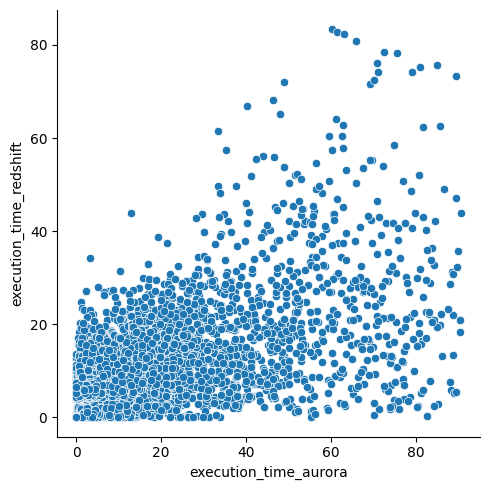

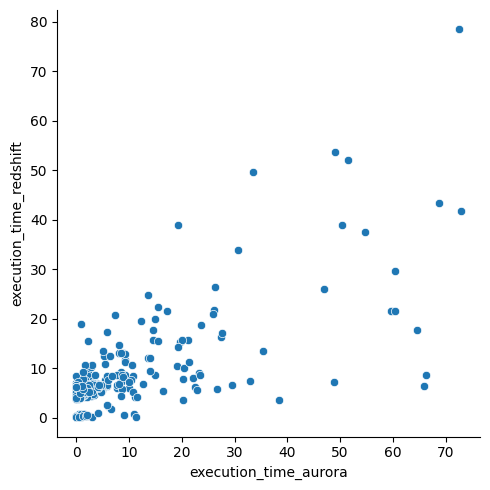

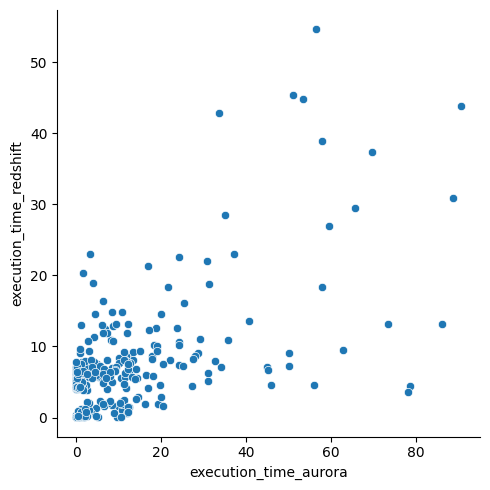

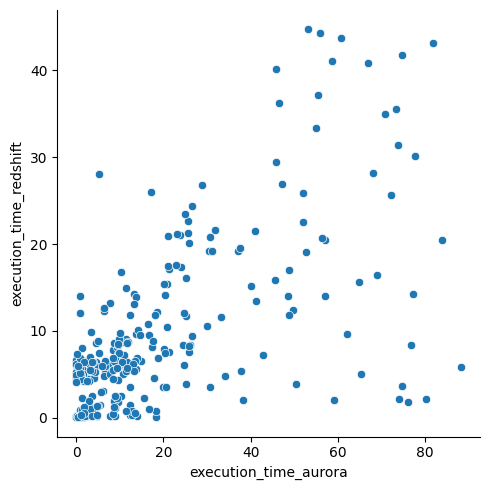

In [5]:
sns.relplot(merged_df, x='execution_time_aurora', y='execution_time_redshift')
sns.relplot(aurora_lean_df, x='execution_time_aurora', y='execution_time_redshift')
sns.relplot(balanced_df, x='execution_time_aurora', y='execution_time_redshift')
sns.relplot(redshift_lean_df, x='execution_time_aurora', y='execution_time_redshift')

In [6]:
table_sizes = {
    "title_type": 11,
    "title": 9777510,
    "title_aka_attribute": 258077,
    "crew": 19112800,
    "principal": 55650408,
    "title_aka_type": 5538746,
    "title_aka": 35667262,
    "title_genre": 15127551,
    "title_alt_type": 8,
    "genre": 28,
    "name_profession": 16160638,
    "principal_character": 27996604,
    "episode": 7418893,
    "rating": 1301002,
    "principal_category": 12,
    "name_known_for_title": 19546344,
    "crew_type": 2,
    "name": 12450720,
}

featurizer = Featurizer(IMDB_TSV.schema, IMDB_TSV.stats, table_sizes)

In [7]:
TRAIN_TOTAL_SAMPLES = 3000
TEST_TOTAL_SAMPLES = 300

source_df = merged_df.sample(frac=1, random_state=0)  # Shuffle dataframe
aurora_better = source_df[source_df["execution_time_aurora"] < source_df["execution_time_redshift"]]
redshift_better = source_df[source_df["execution_time_aurora"] > source_df["execution_time_redshift"]]


def train(frac: float):
    train_aurora_samples = int(frac * TRAIN_TOTAL_SAMPLES)
    train_redshift_samples = TRAIN_TOTAL_SAMPLES - train_aurora_samples
    train_df = pd.concat(
        (
            aurora_better.iloc[:train_aurora_samples],
            redshift_better.iloc[:train_redshift_samples],
        )
    )

    X_train = np.array(train_df["sql"].transform(featurizer.featurize).tolist())
    y_train = (train_df["execution_time_aurora"] < train_df["execution_time_redshift"]).to_numpy().astype('int')

    params = {
        "max_depth": list(range(1, 50)),
        "min_samples_leaf": list(range(1, 50)),
        "criterion": ["gini", "entropy"],
    }
    clf = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=0),
        param_grid=params,
        n_jobs=-1,
        scoring="accuracy",
    )

    clf.fit(X_train, y_train)
    # clf.best_estimator_

    return clf


def test(clf, train_frac, test_frac: float):
    train_aurora_samples = int(train_frac * TRAIN_TOTAL_SAMPLES)
    train_redshift_samples = TRAIN_TOTAL_SAMPLES - train_aurora_samples

    aurora_better_test = aurora_better.iloc[train_aurora_samples:]
    redshift_better_test = redshift_better.iloc[train_redshift_samples:]
    
    test_aurora_samples = int(test_frac * TEST_TOTAL_SAMPLES)
    test_redshift_samples = TEST_TOTAL_SAMPLES - test_aurora_samples

    test_df = pd.concat(
        (
            aurora_better_test.sample(n=test_aurora_samples),
            redshift_better_test.sample(n=test_redshift_samples),
        )
    )

    X_test = np.array(test_df["sql"].transform(featurizer.featurize).tolist())
    y_test = (test_df["execution_time_aurora"] < test_df["execution_time_redshift"]).to_numpy().astype('int')

    prediction = clf.predict(X_test)
    score = clf.score(X_test, y_test)

    min_execution_time = np.minimum(test_df['execution_time_aurora'], test_df['execution_time_redshift'])
    max_execution_time = np.maximum(test_df['execution_time_aurora'], test_df['execution_time_redshift'])
    test_df = test_df.assign(min_execution_time=min_execution_time)
    test_df = test_df.assign(max_execution_time=max_execution_time)

    average_predicted = (
        test_df[prediction == y_test]['min_execution_time'].sum()
        + test_df[prediction != y_test]['max_execution_time'].sum()
    ) / len(test_df)
    all_aurora = test_df['execution_time_aurora'].sum() / len(test_df)
    all_redshift = test_df['execution_time_redshift'].sum() / len(test_df)
    optimal_routing = test_df['min_execution_time'].sum() / len(test_df)
    worst_routing = test_df['max_execution_time'].sum() / len(test_df)

    return score, worst_routing, all_aurora, all_redshift, average_predicted, optimal_routing

In [8]:
for train_frac in (0.1, 0.9):
    clf = train(train_frac)
    score, worst_routing, all_aurora, all_redshift, average_predicted, optimal_routing = test(clf, train_frac, train_frac)
    print(f"{train_frac, train_frac} = {score}")
    print(f"  {worst_routing, all_aurora, all_redshift, average_predicted, optimal_routing}")

(0.1, 0.1) = 0.9
  (21.458879426666666, 20.997003296666666, 8.84960067, 8.820166256666667, 8.387724539999999)
(0.9, 0.9) = 0.9033333333333333
  (8.824023729999999, 5.02254212, 7.46194148, 4.7195002, 3.6604598699999995)


In [9]:
# (0.25, 0.25) = 0.7766666666666666
# (0.25, 0.5) = 0.62
# (0.25, 0.75) = 0.48
# (0.5, 0.25) = 0.76
# (0.5, 0.5) = 0.73
# (0.5, 0.75) = 0.7333333333333333
# (0.75, 0.25) = 0.5833333333333334
# (0.75, 0.5) = 0.71
# (0.75, 0.75) = 0.7966666666666666

In [10]:
# len(train_df[train_df['execution_time_aurora'] < train_df['execution_time_redshift']]) / len(train_df)

In [11]:
# from sklearn.dummy import DummyClassifier

# dummy_clf = DummyClassifier(strategy='constant', constant=1)
# dummy_clf.fit(X_test, y_test)
# dummy_clf.score(X_test, y_test)